![logo](./img/LogoLine_horizon_C3S.png)

# Ice sheet surface elevation change rates

## Introduction

This tutorial will guide you through the process of plotting a map of the average surface elevation change rates across the Greenland or Antarctic ice sheets, using data from the Copernicus Climate Change Service (C3S). Surface elevation change rate data represent the rate at which the ice sheet's surface height is increasing or decreasing over time, which is crucial for understanding ice sheet dynamics and their contribution to sea level rise.

The tutorial uses elevation data from the Climate Data Store (CDS), specifically focusing on data from version 3 for Antarctica, which is the most recent release available up to February 2023. For Greenland, more recent data versions are available.

This NetCDF dataset provides surface elevation change data over the ice sheets, including spatial dimensions (x, y), time (t), and the key variable dhdt for elevation change rates. It is structured to support analysis of temporal and spatial changes in ice sheet elevation.

You will learn how to access and download these datasets from the CDS, compute average elevation change rates over a specified period, and visualize these changes on a map. The tutorial is designed to be easy to follow, providing clear steps along the way.

## Prerequisites and data acquisition

This tutorial is in the form of a Jupyter notebook. It can be run on a cloud environment, or on your own computer. You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://notebooks.gesis.org/binder/jupyter/user/ecmwf-projects--us-training-c3s-0vneba36/doc/tree/srb-claraA3.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/gh-pages/&#95;sources/srb-claraA3.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>
<br><br>

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [1]:
!pip install -q cdsapi

### Import libraries

The data is stored in netCDF4 files. To work with them, several libraries are needed. These are used to retrieve the data, unpack it, run calculations and plot the results.

In [2]:
# CDS API
import cdsapi

# File handling
import shutil
import glob
import os
import zipfile

# Calculations
import numpy as np
import xarray as xr

# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plotting
import matplotlib.pyplot as plt

### Download data using CDS API

This section is provides all necessary settings and input data to successfully run the use cases, and produce the figures. 

### Set up CDS API credentials

We will request data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/). In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [3]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '############'

To download data from the CDS, you must complete three steps;
1. Register for free with the CDS at https://cds.climate.copernicus.eu/#!/home
2. Set up the CDS Application Program Interface (API), as described at https://cds.climate.copernicus.eu/api-how-to
3. Agree to the dataset terms of use - if you have not already done so you will be directed to the correct webpage the first time you try to download data. Accept the terms and conditions, and re-run the downloading code.

## Download data

Select the ice sheet of interest and retrieve the dataset. An example of how to retrieve the data is given on the CDS, under 'Show API request' on the dataset's webpage at https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ice-sheet-elevation-change?tab=form

The dataset comes in a zip file, and may include several files. Only the most recent is necessary - this contains all of the data in previous files, plus the latest update.  

In [4]:
# Define a data directory where the data will be downloaded to
DATADIR = './data_dir'

# Set ice_sheet to the desired ice sheet, either 'antarctica' or 'greenland'
# This will be used to select data, and later to set up plot defaults

ice_sheet = 'greenland'
# ice_sheet = 'antarctica'

if ice_sheet == 'greenland':
    version = '4_0'
    rate_variable = "dhdt" # The variable plotted later
else:
    version = '3_0'
    rate_variable = "sec"

# Download data from the CDS

DL_file = os.path.join(DATADIR, f'{ice_sheet}.zip')
if not os.path.exists(DL_file):
    c = cdsapi.Client(
        url=URL, key=KEY
    )
    c.retrieve(
        'satellite-ice-sheet-elevation-change',
        {
            'variable': 'all',
            'domain': ice_sheet,
            'climate_data_record_type': 'icdr',
            'version': version,
        },
        DL_file
    )


with zipfile.ZipFile(DL_file, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)
# Unpack the zip file and remove the zipped data

latest_file = filelist[0]
print('In the following you are seeing the data from: \n'+latest_file)

2025-01-06 12:07:11,091 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-06 12:07:11,092 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-06 12:07:11,092 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-06 12:07:11,092 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

87a27f7994556a5420594a3dd767277.zip:   0%|          | 0.00/18.3M [00:00<?, ?B/s]

In the following you are seeing the data from: 
./data_dir/C3S_GrIS_RA_SEC_25km_vers4_2024-07-03.nc


## Examine the data

Open the data file and list its contents. These include descriptive comments.

In [5]:
# Open the NetCDF file

ds = xr.open_dataset(latest_file)

# Set "time" as the index for the "t" dimension so that it is possible to index the data by time
ds = ds.set_index(t='time')

# To simplify code later, we will ensure that the latitude and longitude coordinates are named consistently
if "lat" in ds:
    ds = ds.rename({"lat": "latitude"})
if "lon" in ds:
    ds = ds.rename({"lon": "longitude"})

# Then we assign some of the variables as coordinates, for improved handling.
# List of variables that if present, should be changed to coordinates
POTENTIAL_COORDS = [
    "t",
    "latitude",
    "longitude",
    "start_time",
    "end_time",
    "grid_projection",
    "grid_x_bounds",
    "grid_y_bounds",
    "grid_lat_bounds",
    "grid_lon_bounds",
    "time_bounds",
]
# Find any in dataset, and change to coordinates
coords = [coord for coord in POTENTIAL_COORDS if coord in ds]
ds = ds.set_coords(coords)


# Print contents list
print('The data file contains the following:')
ds

The data file contains the following:


<xarray.Dataset> Size: 77MB
Dimensions:          (x: 65, y: 123, t: 385)
Coordinates:
  * x                (x) float32 260B -7.393e+05 -7.143e+05 ... 8.607e+05
  * y                (y) float32 492B -3.478e+06 -3.453e+06 ... -4.281e+05
    start_time       (t) datetime64[ns] 3kB ...
    end_time         (t) datetime64[ns] 3kB ...
    grid_projection  |S1 1B ...
    latitude         (y, x) float32 32kB ...
    longitude        (y, x) float32 32kB ...
  * t                (t) datetime64[ns] 3kB 1991-12-31T23:59:58.468685824 ......
Data variables:
    dh               (y, x, t) float32 12MB ...
    dh_uncert        (y, x, t) float32 12MB ...
    dhdt             (y, x, t) float32 12MB ...
    dhdt_uncert      (y, x, t) float32 12MB ...
    dhdt_stabil      (y, x, t) float32 12MB ...
    dhdt_ok          (y, x, t) int8 3MB ...
    dist             (y, x, t) float32 12MB ...
    land_mask        (y, x) int8 8kB ...
    high_slope       (y, x) int8 8kB ...
    area             (y, x) float32 32kB ...
Attributes: (12/32)
    Title:                Surface Elevation change of the Greenland ice sheet...
    institution:          Copernicus Climate Change Service, DTU Space - Div....
    reference:            Simonsen and Sørensen (2017), Sørensen et al. (2018)
    contact:              copernicus-support@ecmwf.int
    file_creation_date:   2024-07-03 08:41:23.283640
    project:              C3S_312b_Lot4_ice_sheets_and_shelves
    ...                   ...
    netCDF_version:       NETCDF4
    product_version:      v4
    Conventions:          CF-1.7
    keywords:             EARTH SCIENCE CRYOSPHERE GLACIERS/ICE SHEETS/GLACIE...
    license:              C3S general license
    summary:              Surface elevation change rate derived for Greenland...

This NetCDF file contains data related to surface elevation change of the ice sheet. Here's a breakdown of the file structure and its contents:

**Dimensions:** 
- `x`: Projected longitudinal coordinates with values ranging from approximately -739,300 to 860,700 (for Greenland).
- `y`: Projected latitudinal coordinates with values ranging from approximately -3,478,000 to -428,100 (for Greenland).
- `t`: Time coordinates.

**Coordinates**
- A number of coordinate variables which describe the location of the data in time and space, including the cell bounds and the grid projection of the data.

**Data Variables:** 
- Among others, the elevation change is represented in the variable `dhdt` for Greenland and `sec` for Antarctica.

Additional meta-data is included in the file's attributes.


## Calculate averages and plot

The ice sheets are split into 25km by 25km cells. In each cell is a series of surface elevation change rates (called 'sec' for Antarctica or 'dhdt' for Greenland), at times given by the 'time' array. First we select a time-period of interest and calculate the average, we then print the resulting xarray to see the structure data array for the dhdt variable.

In [6]:
# Time range
Start_date = '2011-01-01'
End_date   = '2022-01-31'

# Select data and calculate the mean in the t dimension
ds_mean = ds.sel(t=slice(Start_date, End_date)).mean(dim='t')

# Print the mean data xarray dataarray for the rate of change variable of interest
ds_mean[rate_variable]

<xarray.DataArray 'dhdt' (y: 123, x: 65)> Size: 32kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x                (x) float32 260B -7.393e+05 -7.143e+05 ... 8.607e+05
  * y                (y) float32 492B -3.478e+06 -3.453e+06 ... -4.281e+05
    grid_projection  |S1 1B ...
    latitude         (y, x) float32 32kB ...
    longitude        (y, x) float32 32kB ...

We then plot the data array using matplotlib.

Text(0.5, 0.01, 'Map showing the average surface elevation change rates over the ice sheets from 2011-01-01 to 2022-01-31.\nThe map is centered on Greenland, with changes in elevation indicated by color, ranging from decreases (blue) to increases (red) in meters per year (m/yr).')

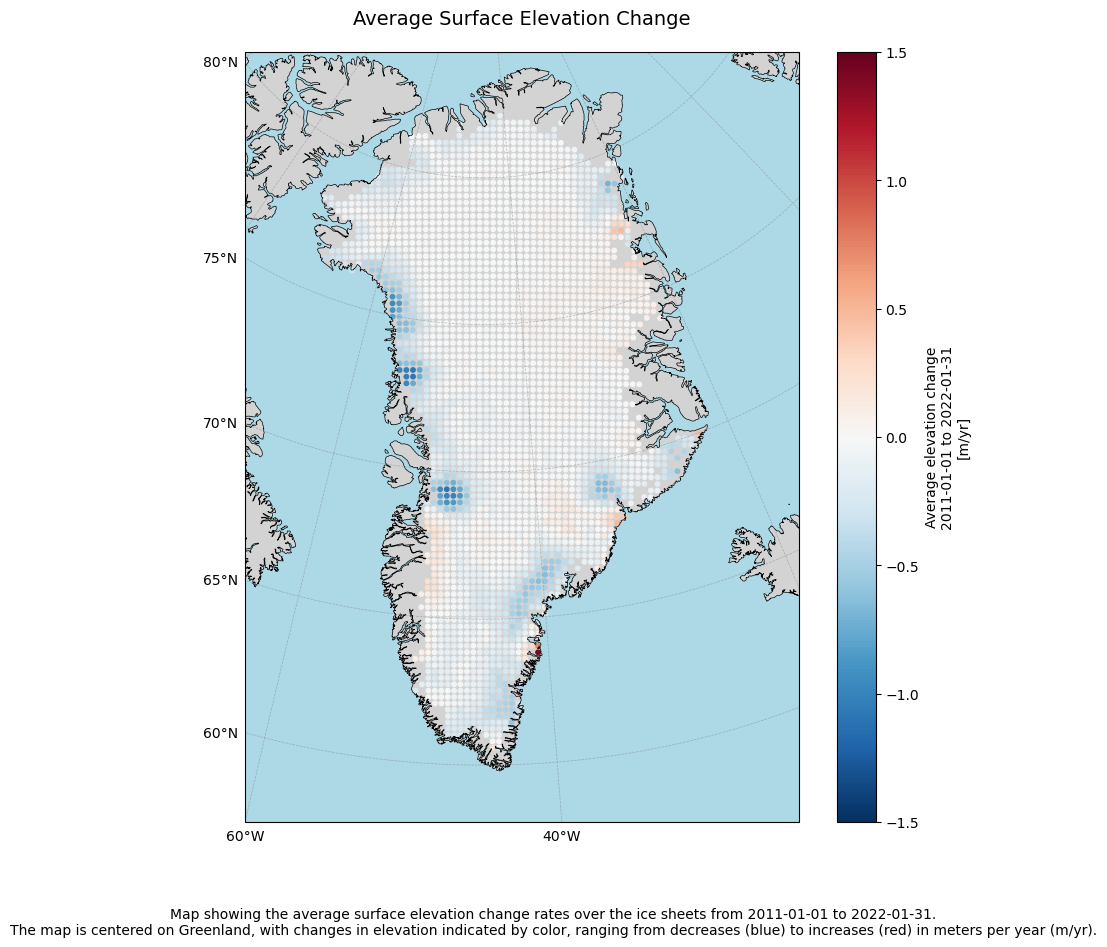

In [8]:
# Create a figure and axis with a specific projection (e.g., Orthographic projection centered on Greenland)
fig = plt.figure(figsize=(10, 10))

# Set some options based on the ice sheet of interest
if 'green' in ice_sheet:
    ext= [-60, -25, 57, 84]
    ax = plt.axes(projection=ccrs.Orthographic(-45, 71))
else:
    ext = [-180, 180, -90, -60]
    ax = plt.axes(projection=ccrs.SouthPolarStereo()) # ?

# Add the coastlines  to the map    
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)

# Set the extent of the map to the longitude and latitude range 
ax.set_extent(ext, crs=ccrs.PlateCarree())

# Add land and ocean features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Remove latitude labels at the top and longitude labels on the right
gl.top_labels = False
gl.right_labels = False
 
# Plot data
sc = ax.scatter(
    ds_mean['longitude'], ds_mean['latitude'], 10, ds_mean[rate_variable], cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin =-1.5,vmax = 1.5
)

# Add colorbar to map
cbar = plt.colorbar(sc, label='Data')

# Add units to colorbar
cbar.set_label(f"Average elevation change\n{Start_date} to {End_date}\n[m/yr]")

# Add title and caption to the plot
title = "Average Surface Elevation Change"
ax.set_title(title, fontsize=14, pad=20)
fig.text(
    0.5, 0.01, 
    f"Map showing the average surface elevation change rates over the ice sheets from {Start_date} to {End_date}.\n"
    f"The map is centered on {'Greenland' if 'green' in ice_sheet else 'Antarctica'}, "
    "with changes in elevation indicated by color, ranging from decreases (blue) to increases (red) in meters per year (m/yr).",
    ha='center', va='center', fontsize=10, color='black'
)

### Why is data missing from the South Pole? 

The change rates series may not have a value at every time - a blank (represented by not-a-number or 'NaN') is left where measurements could not be made or were of low quality. A special case is the interior of the Antarctic ice sheet, below 81.5&deg;S. Five of the six satellites used to make the dataset could not see into this region. All the data there came from CryoSat-2, which has a more tilted orbit. Even CryoSat-2 can only see down to 88&deg;S and so there is a circular region around the South Pole which never contains data. 

This has a further consequence. In the simple averaging calculation below, data from the region seen only by CryoSat-2 will only be available for the CryoSat-2 mission period, which began in 2010, even if the start of the averaging period is before that.

### What would be a good colour palette for the plot?

Many published plots, such as the one on this page https://www.cnet.com/science/climate/nasa-study-reveals-decades-of-antarctic-ice-loss-that-went-under-the-radar/plots, use a red-to-blue colour scale, where red represents ice loss, blue represents gain and the white centre represents no change. This works well if the data range is centred on zero, but looks misleading when it is not. The scale used in the example code, a red-to-green-to-blue scale, is a colourblind accessible alternative.

If the data range is not centred on zero, then the python 'viridis' colour scale, which is also colourblind accessible, is an example of a better choice.

## Key Take Home Points

- **Surface Elevation Change Data**: This dataset provides insights into the average surface elevation change rates of ice sheets over specified periods. It helps in understanding ice sheet dynamics and their contribution to sea level rise.

- **Time Range**: The analysis is conducted over a user-defined time range. This period allows for the assessment of trends and variations in ice sheet elevation over a decade.

- **Spatial Focus**: The data is focused on the two ice sheets, Greenland or Antarctica, depending on the dataset. The visualization uses an orthographic projection to provide a clear view of elevation changes in the selected region.

- **Color Representation**: Elevation changes are represented using a color map, where colors indicate the rate of elevation change in meters per year. Blue shades denote decreases, while red shades indicate increases.

- **Data Source**: The data is sourced from the Copernicus Climate Change Service (C3S), ensuring that it is based on reliable and comprehensive observations.

- **Visualization**: The map visualization is designed to be straightforward, showing the average elevation change across the ice sheet. The map includes features such as coastlines, land, and ocean, along with latitude and longitude gridlines for reference.

